# **BBM409 ASSIGNMENT 3**

        Eylül TUNCEL - 21727801
        Emre KÖSEN   - 21727498

In this assignment, we will try to determine whether a mail is ham or spam with Naive Bayes classifier. Naive Bayes is a simple classification algorith that makes an assumption about the conditional independence of features. In our dataset, there are two columns (text, spam).
* ”text”: the text of the article, could be incomplete
* ”spam”: a label that marks the article as potentially spam or ham
    - 1: spam
    - 0: ham

Below you can see implementation for all parts.

In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [2]:
def split_data(x):
    # start and end points of each fold
    size = int(x.shape[0] / 5)
    # size = 100

    # 1/5 part of the data set as test data
    x_test = x[0:size]

    # 4/5 part of the data set as test data
    x_train = x[size:]
    return x_test, x_train

In [3]:
def vectorizer(x, n_gram):
    # text_col refers to the first column which has mail texts
    text_col = []
    for i in range(x.shape[0]):
        text_col.append(x[i, 0])

    # initialize count vectorizer
    if n_gram == 1:
        count_vectorizer = CountVectorizer(max_df=1.0, min_df=1)
    elif n_gram == 2:
        count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
    # matrix of token counts
    matrix = count_vectorizer.fit_transform(text_col)

    # vocabulary is the array of unique words which appears in all train texts
    vocabulary = count_vectorizer.get_feature_names()
    matrix = matrix.toarray()

    # unique words dictionary is a dict which has all unique words as key and an array [spam count, ham count] as value
    # one example key value pair is { "word" : [ 12, 30 ] ,  , }
    unique_words_dict = dict.fromkeys(vocabulary)
    for key in unique_words_dict:
        # initialize spam and ham count as [0,0] at the beginning
        unique_words_dict[key] = [0, 0]

    count_spam_mails = 0
    count_ham_mails = 0
    total_spam_words = 0
    total_ham_words = 0

    # for all train samples
    for i in range(len(x)):

        # if the sample is HAM
        if x[i][1] == 0:
            count_ham_mails += 1
            for j in range(len(matrix[i])):
                if matrix[i][j] != 0:
                    # increase count by one in unique words dictionary
                    w = vocabulary[j]
                    unique_words_dict[w] = [unique_words_dict.get(w)[0], unique_words_dict.get(w)[1] + 1]
                    total_ham_words += 1

        # if the sample is SPAM
        else:
            count_spam_mails += 1
            for j in range(len(matrix[i])):
                if matrix[i][j] != 0:
                    w = vocabulary[j]
                    unique_words_dict[w] = [unique_words_dict.get(w)[0] + 1, unique_words_dict.get(w)[1]]
                    total_spam_words += 1

    # total mail count of spam and ham mails
    count_mails = [count_spam_mails, count_ham_mails]

    # total word count appeared in spam and ham mails
    total_words_dist = [total_spam_words, total_ham_words]

    return unique_words_dict, count_mails, total_words_dist



In [4]:
def naive_bayes(x_test, unique_words_dict, total_words_dist, n_gram):
    # take all the texts of mails in test data
    text_col = []
    for i in range(x_test.shape[0]):
        text_col.append(x_test[i, 0])

    # initialize count vectorizer
    if n_gram == 1:
        count_vectorizer = CountVectorizer(max_df=1.0, min_df=1)
    elif n_gram == 2:
        count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
    # matrix of token counts in test data
    matrix = count_vectorizer.fit_transform(text_col)
    vocabulary = count_vectorizer.get_feature_names()
    matrix = matrix.toarray()

    # probability of being spam
    prob_spam = total_words_dist[0] / (total_words_dist[0] + total_words_dist[1])
    # probability of being ham
    prob_ham = total_words_dist[1] / (total_words_dist[0] + total_words_dist[1])

    predictions = []
    results = {}

    # Iterate over all test samples
    for i in range(x_test.shape[0]):

        # take log of the probability of being spam mail and being ham mail
        probability_spam = math.log2(prob_spam)
        probability_ham = math.log2(prob_ham)

        # Iterate over all words of one test sample
        for j in range(len(matrix[i])):

            # if matrix[i][j] is a number different than zero that means this word appears in that train sample
            if matrix[i][j] != 0:

                # Spam and ham count starts from 1 because of laplace smoothing
                spam_count = 1
                ham_count = 1

                # We add number of unique words for laplace smoothing
                spam_denominator = total_words_dist[0] + len(unique_words_dict)
                ham_denominator = total_words_dist[1] + len(unique_words_dict)

                word = unique_words_dict.get(vocabulary[j])

                # Check whether word is in training samples or not
                if word is not None:
                    spam_count += word[0]
                    ham_count += word[1]

                # take log of the probabilities and sum them up
                probability_spam += math.log2(spam_count / spam_denominator)
                probability_ham += math.log2(ham_count / ham_denominator)


        # by the naive bayes algorithm , take maximum probability as prediction class
        if probability_spam > probability_ham:
            predictions.append(1)
        else:
            predictions.append(0)

        # result array has two dimensional arrays in it for each test sample
        # test sample x = [ actual class, predicted class ]
        results[i] = [x_test[i][1], predictions[i]]

    return results

In [5]:
def tf_idf(x, stop_words_out):
    # for tf_idf vectorizer, we first seperate the train data as ham an spam
    # their respecttive values should be different for each word
    text_col_spam = []
    text_col_ham = []
    for i in range(x.shape[0]):
        if x[i][1] == 1:
            text_col_spam.append(x[i, 0])
        elif x[i][1] == 0:
            text_col_ham.append(x[i, 0])

    my_stop_words = ENGLISH_STOP_WORDS.union()

    # for spam mails
    count_vectorizer_spam = CountVectorizer()
    matrix = count_vectorizer_spam.fit_transform(text_col_spam)
    # get the vocabularies from spam mails
    vocabulary_spam = count_vectorizer_spam.get_feature_names()
    pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary_spam)), ('tfidf', TfidfTransformer())]).fit(
        text_col_spam)

    spam_tf_idf_arr = pipe['tfidf'].idf_
    # make dictionary of all words with their respective tf_idf values
    spam_tf_idf_dict = {}
    for i in range(len(spam_tf_idf_arr)):
        spam_tf_idf_dict[vocabulary_spam[i]] = spam_tf_idf_arr[i]

    spam_tf_idf_arr = sorted(spam_tf_idf_arr)
    spam_words = []
    for i in range(100):
        val = spam_tf_idf_arr[i]
        for el in spam_tf_idf_dict.keys():
            if spam_tf_idf_dict.get(el) == val:
                spam_words.append(el)
                break

    # for ham mails
    count_vectorizer_ham = CountVectorizer()
    matrix = count_vectorizer_ham.fit_transform(text_col_ham)
    # get the vocabularies from ham mails
    vocabulary_ham = count_vectorizer_ham.get_feature_names()
    pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary_ham)), ('tfidf', TfidfTransformer())]).fit(
        text_col_ham)

    ham_tf_idf_arr = pipe['tfidf'].idf_
    # make dictionary of all words with their respective tf_idf values
    ham_tf_idf_dict = {}
    #create an 
    for i in range(len(ham_tf_idf_arr)):
        ham_tf_idf_dict[vocabulary_ham[i]] = ham_tf_idf_arr[i]

    ham_tf_idf_arr = sorted(ham_tf_idf_arr)
    ham_words = []
    for i in range(100):
        val = ham_tf_idf_arr[i]
        for el in ham_tf_idf_dict.keys():
            if ham_tf_idf_dict.get(el) == val:
                ham_words.append(el)
                break

    spam_words = list(dict.fromkeys(spam_words))
    ham_words = list(dict.fromkeys(ham_words))
    
    # get union of spam and ham words as "s"
    a, b = [spam_words, ham_words]
    s = [x for x in b if x in a]
    # if same words tf_idf value is too close in different classes 
    # that means their freqencies in those class are very similar, therefore not a indication of the class
    # we remove those words
    for i in range(len(s)):
        word = s[i]
        if (spam_tf_idf_dict.get(word) - ham_tf_idf_dict.get(word)) < 1.5:
            if spam_words.count(word) > 0:
                spam_words.remove(word)
            if ham_words.count(word) > 0:
                ham_words.remove(word)

    # if we want to detect non-stop words
    if stop_words_out:
        sp = spam_words.copy()
        for i in range(len(sp)):
            word = sp[i]
            # remove stop words which are in spam words
            if len(my_stop_words.intersection([word])) > 0:
                spam_words.remove(word)

        hm = ham_words.copy()
        for i in range(len(hm)):
            word = hm[i]
            # remove stop words which are in ham words
            if len(my_stop_words.intersection([word])) > 0:
                ham_words.remove(word)

    print("Spam Words", spam_words[:10])
    print("Ham Words", ham_words[:10])
    print()

    
    # for reimplementing naive bayes with tf_idf vectorizer
    total_spam_words_val = 0
    total_ham_words_val = 0
    # create a dictionar which contains all unique words as keys
    # and their respective spam tf_idf values and ham tf_idf values as values 
    # word (key) -> [spam tf_idf , ham tf_idf]
    unique_words_dict = {}
    for el in spam_tf_idf_dict.keys():
        x = spam_tf_idf_dict.get(el)
        unique_words_dict[el] = [x, 0]
        total_spam_words_val += spam_tf_idf_dict.get(el)
    for el in ham_tf_idf_dict.keys():
        x = ham_tf_idf_dict.get(el)
        if unique_words_dict.get(el) is not None:
            unique_words_dict[el] = [unique_words_dict.get(el)[0], x]
        else:
            unique_words_dict[el] = [0, ham_tf_idf_dict.get(el)]
        total_ham_words_val += ham_tf_idf_dict.get(el)

    total_words_dist = [(total_spam_words_val / len(spam_tf_idf_dict)), (total_ham_words_val/ len(ham_tf_idf_dict))]

    dict_copy = unique_words_dict.copy()
    # remove the  words with unspecific tf_idf values (too high or too low)
    # too high value means the word occured very less (once or twice)
    # too high values means the word occured too much so that doesnt't help to distinguish
    for el in dict_copy.keys():
        arr = unique_words_dict.get(el)
        if arr[0] > 6 or arr[0] < 1.5:
            unique_words_dict[el] = [0, unique_words_dict.get(el)[1]]
        if arr[1] > 6 or arr[1] < 1.5:
            unique_words_dict[el] = [unique_words_dict.get(el)[0], 0]

    return unique_words_dict, total_words_dist


In [6]:
# while calculating performance metrics
# True positive = th -> truly predicted ham mail
# False positive = fh -> falsely predicted ham mail
# True negative = ts -> truly predicted spam mail
# False negative = fs -> falsely predicted spam mail
def calculate_performance(results):
    th = 0
    ts = 0
    fh = 0
    fs = 0
    for key, value in results.items():
        # if the mail is ham and predicted as ham
        if value[0] == value[1] and value[1] == 0:
            th += 1
        # if the mail is spam and predicted as spam
        elif value[0] == value[1] and value[1] == 1:
            ts += 1
        # if the mail is spam but predicted as ham
        if value[0] != value[1] and value[1] == 0:
            fh += 1
        # if the mail is ham but predicted as spam
        elif value[0] != value[1] and value[1] == 1:
            fs += 1

    accuracy = (th + ts) / (th + ts + fh + fs)
    precision = th / (th + fh)
    recall = th / (th + fs)
    f1_score = (2 * recall * precision) / (recall + precision)
    return accuracy, precision, recall, f1_score


In [7]:
# this function gets most frequent words which are in spam/ham mails
# but the words appear both in spam and ham mails are didn't accepted
def max_prob_words_by_naive_bayes(unique_words_dict, total_words_dist):
    max_spam_count = 0
    max_spam_word1 = ""
    max_spam_word2 = ""
    max_spam_word3 = ""
    max_ham_count = 0
    max_ham_word1 = ""
    max_ham_word2 = ""
    max_ham_word3 = ""

    for x in unique_words_dict.keys():
        arr = unique_words_dict.get(x)

        # spam
        if arr[0] > max_spam_count and ((arr[1] / total_words_dist[1]) / (arr[0] / total_words_dist[0])) < 0.5:
            max_spam_count = arr[0]
            max_spam_word3 = max_spam_word2
            max_spam_word2 = max_spam_word1
            max_spam_word1 = x

        # ham
        if arr[1] > max_ham_count and ((arr[0] / total_words_dist[0]) / (arr[1] / total_words_dist[1])) < 0.3:
            max_ham_count = arr[1]
            max_ham_word3 = max_ham_word2
            max_ham_word2 = max_ham_word1
            max_ham_word1 = x

    print("Most frequent ham word  : ", max_ham_word1)
    print("Second frequent ham word : ", max_ham_word2)
    print("Third frequent ham word : ", max_ham_word3)
    print()
    print("Most frequent spam word : ", max_spam_word1)
    print("Second frequent spam word : ", max_spam_word2)
    print("Third frequent ham word : ", max_spam_word3)
    print()
    return

In [8]:
# reading data's in the csv file to the numpy array
df = pd.read_csv('./emails.csv')
x = np.array(df.iloc[:, :])

# shuffle the data
np.random.seed(101)
np.random.shuffle(x)
np.random.seed(102)
np.random.shuffle(x)
np.random.seed(103)
np.random.shuffle(x)

# split data %80 train - %20 test
x_test, x_train = split_data(x.copy())

# create dictionary of unique words
unique_words_dict, count_mails, total_words_dist = vectorizer(x_train.copy(), 1)


# **Part 1:**


In [9]:
# PART1
print("PART1 \n------------------------------------------------------------")
max_prob_words_by_naive_bayes(unique_words_dict, total_words_dist)

PART1 
------------------------------------------------------------
Most frequent ham word  :  vince
Second frequent ham word :  enron
Third frequent ham word :  cc

Most frequent spam word :  here
Second frequent spam word :  click
Third frequent ham word :  000



## **1. Part 1: Understanding the data**


For this part we implement a function named "max_prob_words_by_naive_bayes" (you can see in above code). In this function, we only consider frequencies of each word appeared in mails. Each words frequency calculated by count vectorizer whic is predefined in scikit learn library. By this vector we can calculate each words frequency in spam/ham mails. We calculate the frequencies for each word and make a dictionary with key value pair is shown as { word = [ spam count, ham count ] }. With those values we try to predict most usful keywords. When we try to figure out those keywords from our data, we try to select words which are not appeared often in both of the classes. If a word is appeared often in both classes, then this word has no effect on our prediction. 



With these values, we find 3 words which might be useful for us while predicting.

Ham Mails:


| | Word | Statistics |
| --- | --- | --- |
| Most frequent ham word | **vince** | appeared 2248 times in ham mails |
| Second frequent ham word | **enron** | appeared 2081 times in ham mails |
| Third frequent ham word | **cc** | appeared 1765 times in ham mails |



Spam Mails:



| | Word | Statistics |
| --- | --- | --- |
| Most frequent spam word | **here** | appeared 403 times in spam mails |
| Second frequent spam word | **click** | appeared 246 times in spam mails |
| Third frequent spam word | **000** | appeared 137 times in spam mails |

So, as we can see some words appeared more than the others. And this makes that specific word a better indicator of spam/ham mail. As we can see with our eyes too, those words appeared very often in their classes.For example the word "vince" appeared 2248 time in ham mails but there arent any appearence in spam mails. So that makes "vince" a very great indicator of being ham mail. By using those values, we can implement our naive bayes algorithm. As we can see from the words, naive bayes algorithm is appropriate and applicable. While some words indicate being ham, others could indicate being spam. With naive bayes algorithm we can calculate the probability of both cases and make comparison between them. We think naive bayes algorithm is applicable, by looking at the data.

But there is bad side of naive bayes algorithm ehich cannot be detected by looking probabilities of words. Words together in mails creates a context. Naive Bayes algorithm didn't consider context of mails just looking total probabilities one by one.

# **PART 2:**

In [10]:
# PART2
print("PART2 \n------------------------------------------------------------")

#UNIGRAM

# calculate probabilities of all given test data
results = naive_bayes(x_test.copy(), unique_words_dict, total_words_dist, 1)

# calculate performance of the given results
accuracy, precision, recall, f1_score = calculate_performance(results)
print("Unigram Accuracy: ", accuracy)
print("Unigram Precision: ", precision)
print("Unigram recall: ", recall)
print("Unigram F1 score: ", f1_score)
print()


# BIGRAM 

unique_words_dict, count_mails, total_words_dist = vectorizer(x_train.copy(), 2)
results = naive_bayes(x_test.copy(), unique_words_dict, total_words_dist, 2)

accuracy, precision, recall, f1_score = calculate_performance(results)
print("Bigram Accuracy: ", accuracy)
print("Bigram Precision: ", precision)
print("Bigram recall: ", recall)
print("Bigram F1 score: ", f1_score)
print()

PART2 
------------------------------------------------------------
Unigram Accuracy:  0.9921397379912664
Unigram Precision:  0.9964994165694282
Unigram recall:  0.9930232558139535
Unigram F1 score:  0.9947582993593477

Bigram Accuracy:  0.97117903930131
Bigram Precision:  0.9975932611311673
Bigram recall:  0.963953488372093
Bigram F1 score:  0.9804849201655825



## **2. Part 2: Implementing Naive Bayes**

In part2 we implemented Naive Bayes Algorithm. For this purpose we use CountVectorizer first. Count vectorizer creates a matrix which has frequencies of all words. In each row, there is another mail with frequencies of all unique words.
When we implement Naive Bayes algorithm we use this formulation :

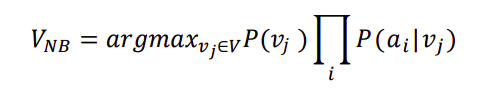
**_________________________________________________________________________________________________________**

By using this formula we compute the log probabilities to prevent numerical underflow when calculating multiplicative probabilities.

$ P(class|mail) = P(class) x P(word1|class) x P(word2|class) x ... x P(wordn|class) $


$ log(P(class|mail)) = log( P(class) x P(word1|class) x P(word2|class) x ... x P(wordn|class) ) $


$ log(P(class|mail)) = log(P(class)) + log(P(word1|class)) + log(P(word2|class)) + ... + log(P(wordn|class)) $


**_________________________________________________________________________________________________________**



And also use "Laplace Smoothing" because we may be encounter words during classification that you havent during training. We implement Laplace Smooothing as follows:


 $ Probability(word|class) = \frac{FrequencyOfWord + 1}{TotalFrequencyOfClass + NumberOfUniqueWords} $ 

**_________________________________________________________________________________________________________**


And also we use Bag of Words (BoW) model which learns a vocabulary from all of the documents, then models each document by counting the number of times each word appears. This model is created by CountVectorizer. 

* **Unigram:**

The occurrences of words in a document(frequency of the word).

Count Vectorizer -> ngram_range=(1, 1)

* **Bigram:** 

The occurrences of two adjacent words in a document.

Count Vectorizer -> ngram_range=(2, 2)


## **3. Part 3:**

In [11]:
 # PART3
print("PART3 \n------------------------------------------------------------")
print("TF-IDF")
unique_words_dict, total_words_dist = tf_idf(x_train.copy(), False)
# calculate probabilities of all given test data
results = naive_bayes(x_test.copy(), unique_words_dict, total_words_dist, 1)

# calculate performance of the given results
accuracy, precision, recall, f1_score = calculate_performance(results)
print("Unigram Accuracy: ", accuracy)
print("Unigram Precision: ", precision)
print("Unigram recall: ", recall)
print("Unigram F1 score: ", f1_score)
print()

print("NON STOP WORDS")
unique_words_dict, total_words_dist = tf_idf(x_train.copy(), True)


PART3 
------------------------------------------------------------
TF-IDF
Spam Words ['here', 'no', 'http', 'business', 'email', 'click', 'best', 'make', 'money', 'only']
Ham Words ['vince', 'enron', 'cc', 'me', 'am', 're', 'kaminski', 'would', 'thanks', '2000']

Unigram Accuracy:  0.9510917030567686
Unigram Precision:  0.9950738916256158
Unigram recall:  0.9395348837209302
Unigram F1 score:  0.9665071770334929

NON STOP WORDS
Spam Words ['http', 'business', 'email', 'click', 'best', 'make', 'money', 'free', 'life', 'offer']
Ham Words ['vince', 'enron', 'cc', 'kaminski', 'thanks', '2000', 'pm', 'ect', 'hou', 'time']



### **3.a) Analyzing effect of the words on prediction**
• **List the 10 words whose presence most strongly predicts that the mail is ham.**

* vince
* enron
* cc
* me
* am
* re
* kaminski
* would
* thanks
* 2000



• **List the 10 words whose absence most strongly predicts that the mail is ham.**

* here 
* no
* http
* business
* email
* click
* best
* make
* money
* only




• **List the 10 words whose presence most strongly predicts that the mail is spam.**

* here 
* no
* http
* business
* email
* click
* best
* make
* money
* only



• **List the 10 words whose absence most strongly predicts that the mail is spam**

* vince
* enron
* cc
* me
* am
* re
* kaminski
* would
* thanks
* 2000

We used TF-IDF to extract the most frequent words in both spam and ham mails. First we split the spam and ham mails to process spam and ham related words seperately. The TF-IDF gives less score for if a word appears so much and more score if words less. A word can appear in both spam and ham mails so we need to eliminate these words. We eliminated the words that appear both in spam and ham mails with score difference less than 1.5. With this we are not dealing the words that appear in spam mails and also appear in ham mails.

When we look to the outputs we see that when the words here, no, http, business, email, click, best, make, money and only appear in a mail that mail is mostly a spam mail. We can conclude that if presence of these words mostly predicts that mail is spam, absence of these words should predict that mail is ham. For ham mails the words that presence mostly predicts that mail is ham are vince, enron, cc, me, am, re, kaminski, would, thanks.

At part4 you can see the accuracy, precision, recall and f1 score values of TF/IDF vectorizer on naive bayes classifier. We reimplement Naive Bayes with tf/idf.

### **3.b) Stopwords**

• **List the 10 non-stopwords that most strongly predict that the mail is
ham**
* vince
* enron
* cc
* kaminski
* thanks
* 2000
* pm
* ect
* hou
* time



• **List 10 non-stopwords that most strongly predict that the mail is
spam**
* http
* business
* email
* click
* best
* make
* money
* free
* life
* offer

Stopwords are the words that ineffective when we process them in computers. We generally filter them before processing. Actually these words are the most common words in any language. Some examples in English are "the", "a", "an", "so", "what". These words don't add much information to the text they appear. So we can eliminate them before process mails. With scikit-learn library we have a list of English stopwords.

After eliminating the stopwords our new top 10 words that mostly predicts that the mail is ham are vince, enron, cc, kaminski, 2000, pm, ect, hou, time. New top 10 words that mostly predicts that the mail is spam are http, business, email, click, best, make, money, free, life, offer.

### **3.c) Analyzing effect of the stopwords**

#### Why might it make sense to remove stop words when interpreting the model?

Stopwords are ineffective in the sentence that thay appear in general. If the stopwords don't add new information to sentence we can remove them. By removing them we are removing unnecessary words and the algorithm deals with the words that has more important information. Also these words might occur too much and be ineffective in probabilty calculations. We can improve computing performance by removing them.

#### Why might it make sense to keep stop words?

Deleting stopwords might affect the information or meaning of the sentence. For specific dataset some stopwords might be decisive when we classify mail is spam or ham. Deleting them might affect the algorithms performance.

Conclusion is that we need to try both removing them and keeping them to measure performance of our model. Based on performance outputs we can remove or keep them.


## **4. Part 4: Calculation of Performance Metrics**
You will compute performance metrics below of your model to measure the success
of your classification method:

### **Unigram**
##### max_df=1, min_df=1

* Unigram Accuracy:  0.9921397379912664
* Unigram Precision:  0.9964994165694282
* Unigram recall:  0.9930232558139535
* Unigram F1 score:  0.9947582993593477

##### Time passed: 56.5368 seconds

---

##### max_df=0.85, min_df=0.01

* Unigram Accuracy:  0.9676855895196507
* Unigram Precision:  0.9963811821471653
* Unigram recall:  0.9604651162790697
* Unigram F1 score:  0.9780935464772055

##### Time passed: 4.8810 seconds

---

##### max_df=0.90 min_df=0.005

* Unigram Accuracy:  0.9764192139737992
* Unigram Precision:  0.997610513739546
* Unigram recall:  0.9709302325581395
* Unigram F1 score:  0.9840895698291102

##### Time passed: 6.9668 seconds

---

##### max_df=0.95 min_df=0.005

* Unigram Accuracy:  0.9764192139737992
* Unigram Precision:  0.997610513739546
* Unigram recall:  0.9709302325581395
* Unigram F1 score:  0.9840895698291102

##### Time passed: 7.2592 seconds

When using CountVectorizer to create a vocabulary of words we can set min_df and max_df values. Min_df value is a cut-off. For better explanation when building vocabulary the function ignores the terms that frequency is lower than the value. Because of very low frequency these words might be ineffective. Max_df is opposite of the min_df. It ignores the terms that frequency is higher than the value. These words might be stop-words and we can get rid of them.

We get best performance with max_df=1 and min_df=1 values but with time trade-off. The running time of the algorithm is high. We can change the max_df and min_df values to shrink our vocabulary and work on smaller set of words. This improves the running time performance but disimproves the accuracy and F1 score.


### **Bigram**

##### max_df=1, min_df=1

* Bigram Accuracy:  0.97117903930131
* Bigram Precision:  0.9975932611311673
* Bigram recall:  0.963953488372093
* Bigram F1 score:  0.9804849201655825

##### Time passed: 471.2127

---

##### max_df=0.85, min_df=0.01

* Bigram Accuracy:  0.9021834061135371
* Bigram Precision:  0.9770408163265306
* Bigram recall:  0.8906976744186047
* Bigram F1 score:  0.9318734793187348

##### Time passed: 4.3780

---

##### max_df=0.90, min_df=0.005

* Bigram Accuracy:  0.9266375545851528
* Bigram Precision:  0.9790123456790123
* Bigram recall:  0.922093023255814
* Bigram F1 score:  0.9497005988023952

##### Time passed: 9.6360

---

##### max_df=0.95, min_df=0.005

* Bigram Accuracy:  0.9266375545851528
* Bigram Precision:  0.9790123456790123
* Bigram recall:  0.922093023255814
* Bigram F1 score:  0.9497005988023952

##### Time passed: 9.6279

We explanied the min_df and max_df values in the Unigram part. With Bigram we again get best performance with min_df=1 and max_df=1 values but running time is too high. We can shrink the vocabulary and gain big improvement in time but we lost accuracy around %6.

### **TF-IDF Vectorizer**



* Unigram Accuracy:  0.9510917030567686
* Unigram Precision:  0.9950738916256158
* Unigram recall:  0.9395348837209302
* Unigram F1 score:  0.9665071770334929

The performance values you see above is obtained by TF/IDF vectorizer on Naive Bayes Implementation. WHat we do to reimplement is firstly we get tf idf values for each word in spam/ham mails. Getting those values of specific class gives us hints about prediction. The minimum valued word is always "subject" because it is the most frequent one in mails. While tf idf value goes higher, the frequnency of the word is decreasing. The maximum valued words are the ones which are only encountered once in mails. For Naive Bayes implementation we get those values in the dictionary, seperated with spam and ham mails. The minmum valued words are not specific enough to make predictions (like "subject") so we drop those words. And also maximum valued words which are encoountered only once, they are not special enough to make predictions. Their frequency is very low and that means it doesn't effect the mail is being spam or ham. The tf_idf values ranges between 1 to 8. BUt we only take the words between 1.5 and 6 because that way our accuracy will increase and we make better prediction with more specified values.

Above you can see accuracy, precision, recall and f1 score of TF-IDF Vectorizer. As you can see the values are very high. They range between 93 to 99. TF-IDF Vectorizer's performance is very high we think, but it's still a little bit behind the Count Vectorizer. While TF-IDF Vectorizer is a great way to detect mails, it is not the best one.